In [1]:
%pip install neuralforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import MAE
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Custom callback to save training losses at each epoch
class SaveTrainingLossCallback(pl.Callback):
    def __init__(self, log_file='epoch_loss_log_window_PatchTST_model_one_year_nifty.txt'):
        self.training_losses = []
        self.log_file = log_file
        self.window_number = 0
        with open(self.log_file, 'w') as f:
            f.write('Epoch,Train_Loss,Window\n')

    def on_train_epoch_end(self, trainer, pl_module):
        # Save the training loss at the end of each epoch
        train_loss = trainer.callback_metrics['train_loss'].item()
        self.training_losses.append(train_loss)
        print(f"Epoch {trainer.current_epoch}: Train Loss = {train_loss}")

        # Log the loss to the file
        with open(self.log_file, 'a') as f:
            f.write(f'{trainer.current_epoch},{train_loss},{self.window_number}\n')

    def set_window_number(self, window_number):
        self.window_number = window_number

# Initialize callbacks
save_loss_callback = SaveTrainingLossCallback()
pl_trainer_kwargs = {"callbacks": [save_loss_callback], "accelerator": "cpu", "devices": 1}

In [4]:

# Load and preprocess the data
csv_file_path = '/content/drive/My Drive/archive/nifty.csv'
nifty_data = pd.read_csv(csv_file_path, parse_dates=['Date'])
non_date_cols = nifty_data.columns.difference(['Date'])  # Exclude Date column
nifty_data[non_date_cols] = nifty_data[non_date_cols].apply(pd.to_numeric, errors='coerce')
nifty_data.dropna(subset=['MACD_Signal'], inplace=True)
nifty_data.set_index('Date', inplace=True)
nifty_data = nifty_data.asfreq('B', method='pad')

# Detect problematic entries and where conversion to numeric fails
non_numeric_data = nifty_data.apply(lambda x: pd.to_numeric(x, errors='coerce')).isnull()

# Print rows that have non-numeric values
#print(nifty_data[non_numeric_data.any(axis=1)])
# Check for missing values and print the row and column numbers where they occur
missing_data = nifty_data[nifty_data.isnull().any(axis=1)]  # Get rows with any NaN values

print("Rows with missing values:")
print(missing_data)


# Create scalers
scaler_close = MinMaxScaler()
nifty_data['Open_Close_Diff'] = nifty_data['Open'] - nifty_data['Close']
nifty_data['Close'] = scaler_close.fit_transform(nifty_data[['Close']])

# Initialize variables
training_end_date = nifty_data.index.max() - pd.DateOffset(months=3)  # Train using last 1 year of data
final_predictions = []



Rows with missing values:
Empty DataFrame
Columns: [Open, High, Low, Close, Stoch_K, Stoch_D, RSI, Upper_Band, Middle_Band, Lower_Band, MACD, MACD_Signal, MACD_Hist, ADX]
Index: []


In [8]:
# Define the window management and model training class
class ModelTrainer:
    def __init__(self, data, scaler_close, save_loss_callback, pl_trainer_kwargs):
        self.data = data
        self.scaler_close = scaler_close
        self.save_loss_callback = save_loss_callback
        self.pl_trainer_kwargs = pl_trainer_kwargs

    def train_model(self, train_data, window_number):
        # Set the window number for the callback
        self.save_loss_callback.set_window_number(window_number)

        # Prepare the training data
        Y_train_df = train_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
        Y_train_df['unique_id'] = 'niftyN'

        # Initialize and train the iTransformer model
        model = PatchTST(
            h=7,  # Forecast horizon
            input_size=60,  # Input window size
            encoder_layers=2,  # Similar to e_layers in iTransformer
            n_heads=8,  # Same as in iTransformer
            hidden_size=512,  # Same as in iTransformer
            linear_hidden_size=2048,  # Similar to d_ff in iTransformer
            dropout=0.1,  # Same as in iTransformer
            attn_dropout=0.1,  # Using the same value as dropout
            patch_len=16,  # Default value for PatchTST
            stride=8,  # Default value for PatchTST
            revin=True,  # Default value for PatchTST
            activation='gelu',  # Default value for PatchTST
            res_attention=True,  # Default value for PatchTST
            loss=MAE(),  # Same as in iTransformer
            learning_rate=0.001,  # Same as in iTransformer
            max_steps=50,  # Same as in iTransformer
        )

        # NeuralForecast object to handle model training
        nf = NeuralForecast(models=[model], freq='B')
        nf.fit(df=Y_train_df)

        # Generate future dataframe automatically
        futr_df = nf.make_future_dataframe()

        # Generate predictions
        forecasts = nf.predict(futr_df=futr_df)

        pred_values = self.scaler_close.inverse_transform(forecasts[['PatchTST']].values)
        dates = futr_df['ds']

        return dates, pred_values


In [9]:
# Initialize the trainer
trainer = ModelTrainer(nifty_data, scaler_close, save_loss_callback, pl_trainer_kwargs)

# Training and prediction loop
window_number = 1
while True:
    train_data = nifty_data.loc[:training_end_date]
    print(f"Training window {window_number}: from {train_data.index.min()} to {train_data.index.max()}")

    # Train the model and get predictions
    dates, pred_values = trainer.train_model(train_data, window_number)

    if len(dates) == 0:
        print("No future dates were generated. Exiting the loop.")
        break

    # Store the predictions
    predictions_df = pd.DataFrame({'Date': dates, 'Predicted Value': pred_values.flatten()})
    final_predictions.append(predictions_df)

    # Update training_end_date for the next window only if dates exist
    training_end_date = dates.iloc[-1] if len(dates) > 0 else training_end_date

    # Break if we reach the end of the data
    if training_end_date >= nifty_data.index.max():
        break

    window_number += 1

INFO:lightning_fabric.utilities.seed:Seed set to 1


Training window 1: from 1996-02-19 00:00:00 to 2024-06-05 00:00:00


/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 6.3 M  | train
-----------------------------------------------------------
6.3 M     Trainable params
2         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | Con

Training window 2: from 1996-02-19 00:00:00 to 2024-06-14 00:00:00


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | Con

Training window 3: from 1996-02-19 00:00:00 to 2024-06-25 00:00:00


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(


Training window 4: from 1996-02-19 00:00:00 to 2024-07-04 00:00:00


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 6.3 M  | train
-----------------------------------------------------------
6.3 M     Trainable params
2         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)
65        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | Con

Training window 5: from 1996-02-19 00:00:00 to 2024-07-15 00:00:00


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1


Training window 6: from 1996-02-19 00:00:00 to 2024-07-24 00:00:00


/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 6.3 M  | train
-----------------------------------------------------------
6.3 M     Trainable params
2         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | Con

Training window 7: from 1996-02-19 00:00:00 to 2024-08-02 00:00:00


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(


Training window 8: from 1996-02-19 00:00:00 to 2024-08-13 00:00:00


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 6.3 M  | train
-----------------------------------------------------------
6.3 M     Trainable params
2         Non-trainable params
6.3 M     Total params
25.369    Total estimated model params size (MB)
65        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | Con

Training window 9: from 1996-02-19 00:00:00 to 2024-08-22 00:00:00


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | Con

Training window 10: from 1996-02-19 00:00:00 to 2024-09-02 00:00:00


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [11]:
# Combine predictions and save
all_predictions_df = pd.concat(final_predictions, ignore_index=True)
output_csv_file = '/content/drive/My Drive/archive/prediction_using_window_method_PatchTST_model_6m_nifty.csv'
all_predictions_df.to_csv(output_csv_file, index=False)

print(f"Predictions saved to {output_csv_file}")

# Print the logged training losses
print("Training Losses:", save_loss_callback.training_losses)


Predictions saved to /content/drive/My Drive/archive/prediction_using_window_method_PatchTST_model_6m_nifty.csv
Training Losses: []


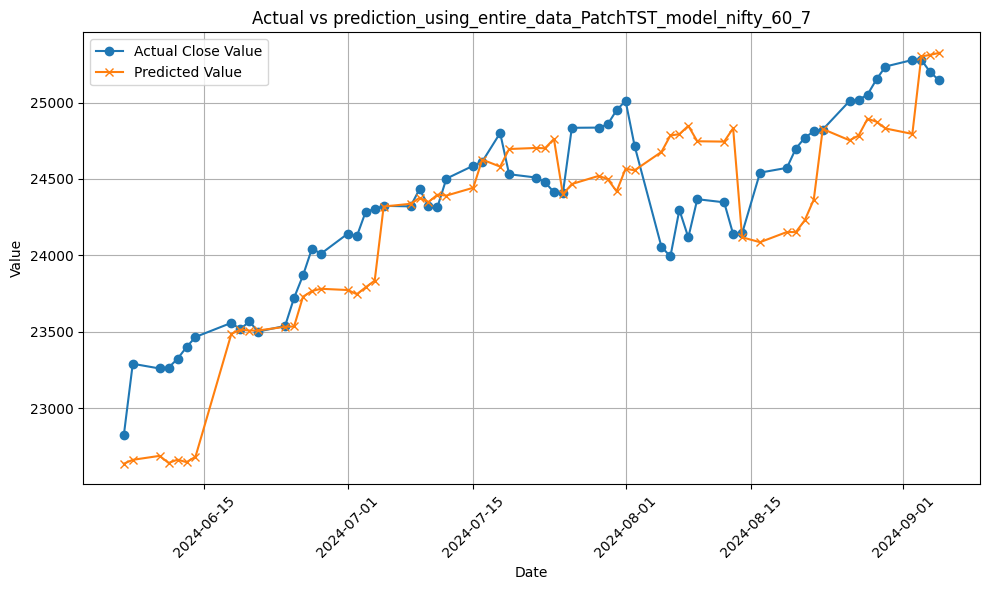

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

# Load the actual data from the CSV file
#actual_csv_path = '/home/raj/Rajarshi/Term Project/notebook_files/data/niftyN.NS_day_2023.csv'
actual_csv_path = csv_file_path
actual_df = pd.read_csv(actual_csv_path)

# Load the predicted data from the CSV file
#predicted_csv_path = '/home/raj/Rajarshi/Term Project/rajarshi_code/itransformer_file/prediction_using_entire_data_itransformer_model.csv'
predicted_csv_path = output_csv_file
predicted_df = pd.read_csv(predicted_csv_path)

# Convert the 'Date' columns to a consistent datetime format for both DataFrames
actual_df['Date'] = pd.to_datetime(actual_df['Date'], errors='coerce')
predicted_df['Date'] = pd.to_datetime(predicted_df['Date'], errors='coerce')

# Drop rows with invalid dates (NaT)
actual_df = actual_df.dropna(subset=['Date'])
predicted_df = predicted_df.dropna(subset=['Date'])

# Merge the DataFrames on the 'Date' column, keeping only the matching dates
merged_df = pd.merge(predicted_df, actual_df, on='Date', how='inner')

# Print the matched dates for verification
# print("Matched Dates:\n", merged_df['Date'])

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Actual Close Value', marker='o')
plt.plot(merged_df['Date'], merged_df['Predicted Value'], label='Predicted Value', marker='x')

# If 'Window Start' and 'Window End' columns are present, add vertical markers
if 'Window Start' in predicted_df.columns and 'Window End' in predicted_df.columns:
    for i in range(len(predicted_df)):
        plt.axvline(predicted_df['Window Start'].iloc[i], color='green', linestyle='--', label='Window Start' if i == 0 else '')
        plt.axvline(predicted_df['Window End'].iloc[i], color='red', linestyle='--', label='Window End' if i == 0 else '')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
title = 'Actual vs prediction_using_entire_data_PatchTST_model_nifty_60_7'
plt.title(title)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()

# Specify the folder where you want to save the plot
output_folder = '/content/drive/My Drive/archive/'

# Ensure the folder exists, if not, create it
os.makedirs(output_folder, exist_ok=True)

# Use the plot title for the filename, replacing spaces with underscores and converting to lowercase
filename = f'{title.replace(" ", "_").lower()}.png'

# Save the plot in the specified folder with the generated filename
plt.savefig(os.path.join(output_folder, filename), format='png', dpi=300)

# Show the plot
plt.show()